In [4]:
# Importation des librairies Python nécessaires
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Utils 
import os
import gc
import time
import missingno as msno
from contextlib import contextmanager


# Librairie de modélisation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [24]:
# Affichage des erreurs
import warnings
warnings.filterwarnings("ignore")

<p class="h2"; style="color:green; text-align:left; background-color:white"> Loading and reading datasets </p>

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [10]:
def read_datasets():   
    with timer("Datasets loaded"):
        print("Loading data ... ")
        app_train = pd.read_parquet('data/application_train.parquet')
        print("\tapplication_train cols_num: {}, obervations: {}".format(len(app_train.columns),
                                                                         app_train.shape[0]))
        
        app_test = pd.read_parquet('data/application_test.parquet')
        print("\tapplication_test cols_num: {}, obervations: {}".format(len(app_test.columns), 
                                                                        app_test.shape[0]))
        
        df_initial = pd.read_parquet('data/data_initial.parquet')
        print("\tdf_initial cols_num: {}, obervations: {}".format(len(df_initial.columns), 
                                                                            df_initial.shape[0]))
        df_final = pd.read_parquet('data/data_final.parquet')
        print("\tdf_final cols_num: {}, obervations: {}".format(len(df_final.columns), 
                                                              df_final.shape[0]))
        
    return app_train, app_test, df_initial, df_final

In [11]:
app_train, app_test, df_initial, df_final = read_datasets()

Loading data ... 
	application_train cols_num: 122, obervations: 307511
	application_test cols_num: 121, obervations: 48744
	df_initial cols_num: 124, obervations: 356255
	df_final cols_num: 192, obervations: 356255
Datasets loaded - done in 2s


In [12]:
# Fonction permettant d'avoir une description du dataset

def dataset_overview(df):
    ''' function taking a dataframe in input and prints a dataframe summary containing
    number of rows, columns, missing cells and duplicate rows'''
    
    print('******** Dataset Overview *****\n')
    
    print ('Shape of the Dataset : {}'.format(df.shape))
    print ('Number of variables : {}'.format(df.shape[1]))
    print (' - Num. Quantitative variables : {}'.format(len(df.select_dtypes(include=["float64","int64"]).columns)))
    print (' - Num. Catégorielles variables : {}'.format(len(df.select_dtypes(include=["object"]).columns)))
    print ('Number of obervations : {}'.format(df.shape[0]))
    print ('Number of cells : {}'.format(df.size))
    print ('Missing cells : {}'.format(df.isna().sum().sum()))
    print ('Missing cells in % : {:.2%}'.format(df.isna().sum().sum()/(df.size)))
    print ('Duplicate rows : {}'.format(len(df)-len(df.drop_duplicates())))
    print ('Duplicate rows in % : {:.4%}'.format((len(df)-len(df.drop_duplicates())) / (df.shape[0])))
    print("\n************** End ************")

In [17]:
# Fonction qui renvoie la proportion de NaN sur l'ensemble du dataset
def print_proportion_nan(df):
    print('Taille du jeu de données : ', df.shape)
    print(' --> Proportion de NaN : {:.2%}'.format(df.isna().sum().sum()/(df.shape[0]*df.shape[1]))) 
              
    return None

In [13]:
dataset_overview(df_initial)

******** Dataset Overview *****

Shape of the Dataset : (356255, 124)
Number of variables : 124
 - Num. Quantitative variables : 108
 - Num. Catégorielles variables : 16
Number of obervations : 356255
Number of cells : 44175620
Missing cells : 10556884
Missing cells in % : 23.90%
Duplicate rows : 0
Duplicate rows in % : 0.0000%

************** End ************


In [14]:
dataset_overview(df_final)

******** Dataset Overview *****

Shape of the Dataset : (356255, 192)
Number of variables : 192
 - Num. Quantitative variables : 176
 - Num. Catégorielles variables : 16
Number of obervations : 356255
Number of cells : 68400960
Missing cells : 18488785
Missing cells in % : 27.03%
Duplicate rows : 0
Duplicate rows in % : 0.0000%

************** End ************


In [15]:
def cat_num_variable(df):
    
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    ignore_features = ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']
    all_numeric_columns = df.select_dtypes(exclude=['object']).columns.to_list()
    numeric_columns = [col for col in all_numeric_columns if col not in ignore_features]
    
    print("Number of categorical features: ", len(categorical_columns))
    print("First 05 cat. features :", cat_columns[:5])
    print("\nNumber of categorical features: ",len(numeric_columns))
    print("First 05 num. Features :",num_columns[:5], "\n")
    
    return categorical_columns, numeric_columns

In [16]:
#cat_columns, num_columns = cat_num_variable(df_initial)

<p class="h2"; style="color:green; text-align:left; background-color:white"> Preprocessing - preparing data for modeling</p>

In [20]:
def new_features_creation(df):
    
    df_features = df.copy()
    
    df_features['DAYS_EMPLOYED_PERC'] = df_features['DAYS_EMPLOYED'] / df_features['DAYS_BIRTH']
    df_features['INCOME_CREDIT_PERC'] = df_features['AMT_INCOME_TOTAL'] / df_features['AMT_CREDIT']
    df_features['INCOME_PER_PERSON'] = df_features['AMT_INCOME_TOTAL'] / df_features['CNT_FAM_MEMBERS']
    df_features['ANNUITY_INCOME_PERC'] = df_features['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df_features['PAYMENT_RATE'] = df_features['AMT_ANNUITY'] / df_features['AMT_CREDIT']
    
    return df_features 

In [18]:
def nan_imputation(df):
    
    with timer("Filtering cols with a given % of missing_rate "):
        # deleting all features with more than 
        missing_rate = df.isna().sum()/df.shape[0] 
        df1 = df[df.columns[missing_rate < 0.60]]
    
        # Droping all row containing Nan for feature with less than 1% of Nan
        less_one_percent = df.columns[missing_rate < 0.010].to_list()
        df2 = df1.dropna(subset=less_one_percent)
   
    with timer("Imputing numeric nan value with median "):
        # Filling missing numeric value with median 
        df3 = df2.fillna(df2.median())
    
    with timer("Imputing categorical nan value with Unknown "):
        # Filling missing catégorical value with Unknown
        categorical_columns = [col for col in df3.columns if df3[col].dtype == 'object']
        for col in categorical_columns:
            df3[col] = df3[col].replace(np.nan, 'Unknown')
    
    df_imputed = df3.copy()
    
    num_features_deleted = df.shape[1] - df_imputed.shape[1]
    num_observations_deleted = df.shape[0] - df_imputed.shape[0]
    
    print("\nTaille du jeu de donnée avant imputation: ", df.shape)
    print("Taille du jeu de donnée après imputation: ", df_imputed.shape)
    print(f"\tSoit {num_features_deleted} variables et {num_observations_deleted} observations supprimées")
    print('Proportion de données supprimés : {:.4%}'.format(num_observations_deleted/(df.shape[0]*df.shape[1])))
    
    return df_imputed

In [19]:
def removing_outliers(df):
    
    df = df[df['CODE_GENDER'] != 'XNA']
    
    cols_with_outlier = ["CNT_FAM_MEMBERS","AMT_INCOME_TOTAL","AMT_ANNUITY", "DAYS_EMPLOYED",
                         "OBS_60_CNT_SOCIAL_CIRCLE", "OBS_30_CNT_SOCIAL_CIRCLE", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                         "REGION_POPULATION_RELATIVE", "AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_QRT"] 
    
    for col in cols_with_outlier:
        df = df[df[col] != df[col].max()]
    
    return df 

In [21]:
from sklearn.preprocessing import MinMaxScaler

def features_encoding(df):
    
    with timer("Encoding categorical features "):
        # Encode des variable catégorielles
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
        df_hot_encode = pd.get_dummies(df, columns= categorical_columns)
    
    with timer("Scaling numeric features "):
        # Standardisation des variables numériques 
        ignore_features = ['is_train', 'is_test', 'TARGET', 'SK_ID_CURR']
        features_to_scaled = [col for col in df_hot_encode.columns if col not in ignore_features]
     
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(df_hot_encode[features_to_scaled])     
        df_scaled = pd.DataFrame(df_scaled, columns=features_to_scaled, index=df['SK_ID_CURR'])
    
    df_encoded = pd.merge(df_hot_encode[ignore_features], df_scaled, on='SK_ID_CURR')
    
    return df_encoded

In [22]:
def preprocessing(df) :
    
    with timer("Preparing data for modeling "):
        df = new_features_creation(df)
        df = nan_imputation(df)
        df = removing_outliers(df)
        df = features_encoding(df)
          
    ignore_features = ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']
    relevant_features = [col for col in df.columns if col not in ignore_features]
    
    trainX = df[df['is_train'] == 1][relevant_features + ['TARGET']]
    testX = df[df['is_test'] == 1][relevant_features]
    
    trainy = trainX['TARGET']
    
    return trainX, testX, trainy

In [26]:
trainX_i, testX_i, trainy_i = preprocessing(df_initial)

Filtering cols with a given % of missing_rate  - done in 2s
Imputing numeric nan value with median  - done in 4s
Imputing categorical nan value with Unknown  - done in 1s

Taille du jeu de donnée avant imputation:  (356255, 129)
Taille du jeu de donnée après imputation:  (352303, 112)
	Soit 17 variables et 3952 observations supprimées
Proportion de données supprimés : 0.0086%
Encoding categorical features  - done in 1s
Scaling numeric features  - done in 2s
Preparing data for modeling  - done in 15s


In [25]:
trainX_f, testX_f, trainy_f = preprocessing(df_final)

Filtering cols with a given % of missing_rate  - done in 3s
Imputing numeric nan value with median  - done in 11s
Imputing categorical nan value with Unknown  - done in 1s

Taille du jeu de donnée avant imputation:  (356255, 197)
Taille du jeu de donnée après imputation:  (352303, 156)
	Soit 41 variables et 3952 observations supprimées
Proportion de données supprimés : 0.0056%
Encoding categorical features  - done in 1s
Scaling numeric features  - done in 2s
Preparing data for modeling  - done in 26s


<p class="h2"; style="color:green; text-align:left; background-color:white"> Spliting data into training and validation sets</p>

#### Spiting Initial data

In [295]:
from sklearn.model_selection import train_test_split

X = trainX_i.drop("TARGET", axis=1)
y = trainy_i.values.reshape(-1,1)

seed = np.random.seed(42)

# Split. into train and test set 
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                   random_state=seed)

X_train_i.shape, X_test_i.shape, y_train_i.shape, y_test_i.shape

((170139, 229), (72917, 229), (170139, 1), (72917, 1))

#### Spliting final data

In [28]:
from sklearn.model_selection import train_test_split

X = trainX_f.drop("TARGET", axis=1)
y = trainy_f.values.reshape(-1,1)

seed = np.random.seed(42)

# Split. into train and test set 
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                   random_state=seed)

X_train_f.shape, X_test_f.shape, y_train_f.shape, y_test_f.shape

((170139, 273), (72917, 273), (170139, 1), (72917, 1))

<p class="h2"; style="color:green; text-align:left; background-color:white"> Modeling </p>

<p class="h3"; style="color:blue"> Defining Evaluation Metrics </p>

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report


def model_eval(model):
    train_accuracy =  model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test) 
    
    return print(f"Train accuracy: {train_accuracy},\nTest Accuracy: {test_accuracy}")


def evaluation_metrics(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    #y_pred_probs = model.predict_proba(X_test)
    
   # """Display a fancy confusion matrix"""
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    
    
    accuracy = accuracy_score(y_test, y_pred) 
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    score_f1 = f1_score(y_test, y_pred)
    
    #average_precision = average_precision_score(y_test, y_scores)
   
    #roc_auc = roc_auc_score(y_test, y_pred_probs)
    
    
    metrics = {"accuracy": (accuracy*100).round(2),
                "precision": (precision*100).round(2),
               "recall": (recall*100).round(2),
               "f1_score": (score_f1*100).round(2),
               #"roc_auc": (roc_auc).round(3)
              }
    
    report = classification_report(y_test, y_pred)
    
    return accuracy, precision, recall, f1_score, metrics, report, mat
    #return accuracy, precision, recall, f1_score, roc_auc, metrics, report, mat
    
def evaluation(model, X_test, y_test):

    accuracy, precision, recall, f1_score, metrics, report, mat = evaluation_metrics(model, X_test, y_test)
 
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)  #on se base sur la probabilité d'être en défaut de paiement
    
    print('AUC : %0.4f\n' %roc_auc)
    print("Classification report:\n", report)   
    print("Evaluation metrics:\n", metrics)
    print("\n")
    print("Confusion Matrix\n", mat)   

In [304]:
from sklearn.model_selection import learning_curve

def tunned_learning_curve(model, X_train, y_train):
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    
    with timer("Model learning"): 
        N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                              cv=5, scoring="accuracy",
                                              train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(10, 5))
    plt.plot(N, train_score.mean(axis=1), label="train score")
    plt.plot(N, val_score.mean(axis=1), label="validation score")
    plt.legend()

<p class="h3"; style="color:blue"> Baseline Model </p>

In [31]:
from sklearn.dummy import DummyClassifier
np.random.seed(42)

# Instancier un modèle
dummy_clf_model = DummyClassifier()
    
# Entraîner le pipeline modèle 
dummy_clf_model.fit(X_train_i, y_train_i)

DummyClassifier()

In [46]:
evaluation(model=dummy_clf_model, X_test=X_test_i, y_test=y_test_i)

AUC : 0.5000

Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     66437
           1       0.00      0.00      0.00      6480

    accuracy                           0.91     72917
   macro avg       0.46      0.50      0.48     72917
weighted avg       0.83      0.91      0.87     72917

Evaluation metrics:
 {'accuracy': 91.11, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}


Confusion Matrix
         pred_0  pred_1
test_0   66437       0
test_1    6480       0


#### Baseline Logistic Regression Model 

In [296]:
from sklearn.ensemble import HistGradientBoostingClassifier
np.random.seed(42)

# Instancier un modèle
log_reg_model_0 = LogisticRegression()
    
# Entraîner le pipeline modèle 
log_reg_model_0.fit(X_train_i, y_train_i)

LogisticRegression()

In [297]:
evaluation(model=log_reg_model_0, X_test=X_test_i, y_test=y_test_i)

AUC : 0.5049

Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     66437
           1       0.45      0.01      0.02      6480

    accuracy                           0.91     72917
   macro avg       0.68      0.50      0.49     72917
weighted avg       0.87      0.91      0.87     72917

Evaluation metrics:
 {'accuracy': 91.09, 'precision': 45.0, 'recall': 1.11, 'f1_score': 2.17}


Confusion Matrix
         pred_0  pred_1
test_0   66349      88
test_1    6408      72


In [306]:
#tunned_learning_curve(model=log_reg_model_0, X_train=X_test_i, y_train=y_train_i)

<p class="h3"; style="color:blue"> Model Training on various models </p>

We can train a set of models on the churn dataset and compare their performance. To simplify this process, we will use the sklearn library and utilize the model.fit() api to train the model while recording train and test accuracy. The following models are trained:

- Naive Bayes
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosted Tree
- Multilayer Perceptron

In [47]:
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

In [188]:
#@title
import time
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 


def train_model(model, X_train, X_test, y_train, y_test): 

    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time

    train_accuracy =  pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test) 
    
    y_pred = model["clf"].predict(X_test)
    y_pred_proba = model["clf"].predict_proba(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    score_f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    
    
    cm_list = []
    cm_list.append(confusion_matrix(y_test, y_pred))
    
    model_details = {"name": model["name"], 
                     "train_accuracy":train_accuracy,
                     "test_accuracy":test_accuracy, 
                     "precision": (precision*100).round(2),
                     "recall": (recall*100).round(2),
                     "f1_score": (score_f1*100).round(2),
                     'AUC':roc_auc.round(4),
                     "train_time": train_time, 
                     "model": pipe}
    return model_details


models =[
          {"name": "Baseline classifier", "clf": DummyClassifier()},
          {"name": "Naive Bayes", "clf": GaussianNB()},
          {"name": "Logistic regression", "clf": LogisticRegression()}, 
          {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier()},
          {"name": "Hist Gradient Boosting", "clf": HistGradientBoostingClassifier()},
          {"name": "XGB Classifier", "clf": XGBClassifier()},
        ]

#### Training and running the models

In [106]:
trained_models = [] #  keep track of all details for models we train

for model in models:
    with timer(f"running {model}"):
        model_details = train_model(model, X_train_i, X_test_i, y_train_i, y_test_i) 
        trained_models.append(model_details)

running {'name': 'Baseline classifier', 'clf': DummyClassifier()} - done in 2s
running {'name': 'Naive Bayes', 'clf': GaussianNB()} - done in 3s
running {'name': 'Logistic regression', 'clf': LogisticRegression()} - done in 6s
running {'name': 'Decision Tree', 'clf': DecisionTreeClassifier()} - done in 22s
running {'name': 'Random Forest', 'clf': RandomForestClassifier()} - done in 98s
running {'name': 'Hist Gradient Boosting', 'clf': HistGradientBoostingClassifier()} - done in 12s
running {'name': 'XGB Classifier', 'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=

In [107]:
trained_models

[{'name': 'Baseline classifier',
  'train_accuracy': 0.9121483022704965,
  'test_accuracy': 0.911131834825898,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0,
  'AUC': 0.5,
  'train_time': 1.193725824356079,
  'model': Pipeline(steps=[('scaler', StandardScaler()), ('clf', DummyClassifier())])},
 {'name': 'Naive Bayes',
  'train_accuracy': 0.12881232404093124,
  'test_accuracy': 0.12969540710671038,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0,
  'AUC': 0.5,
  'train_time': 1.5351200103759766,
  'model': Pipeline(steps=[('scaler', StandardScaler()), ('clf', GaussianNB())])},
 {'name': 'Logistic regression',
  'train_accuracy': 0.9121953226479526,
  'test_accuracy': 0.911131834825898,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0,
  'AUC': 0.5,
  'train_time': 5.509588956832886,
  'model': Pipeline(steps=[('scaler', StandardScaler()), ('clf', LogisticRegression())])},
 {'name': 'Decision Tree',
  'train_accuracy': 1.0,
  'test_accuracy': 0.8405035862693199,
  '

In [108]:
len(trained_models)

7

In [109]:
for i in range(len(trained_models)):
    print(f"{trained_models[i]['name']} - AUC: {trained_models[i]['AUC']}")

Baseline classifier - AUC: 0.5
Naive Bayes - AUC: 0.5
Logistic regression - AUC: 0.5
Decision Tree - AUC: 0.5135
Random Forest - AUC: 0.5
Hist Gradient Boosting - AUC: 0.5
XGB Classifier - AUC: 0.5


### Visualizing Accuracy and Run time

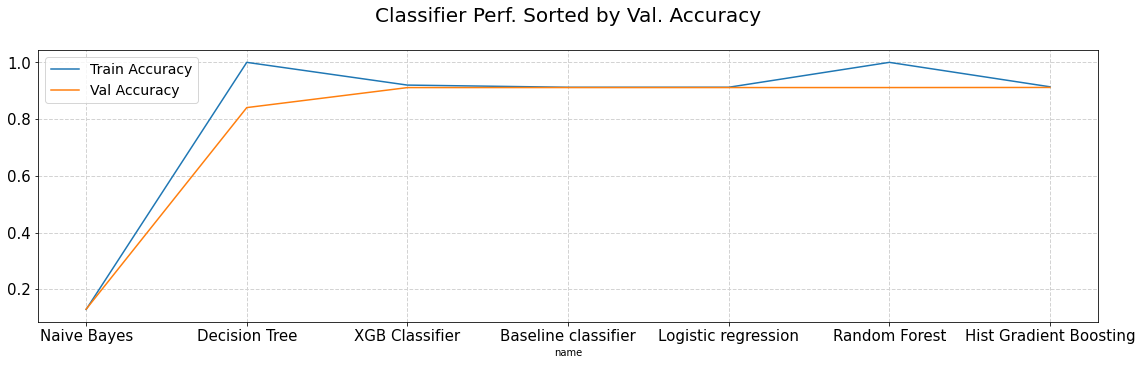

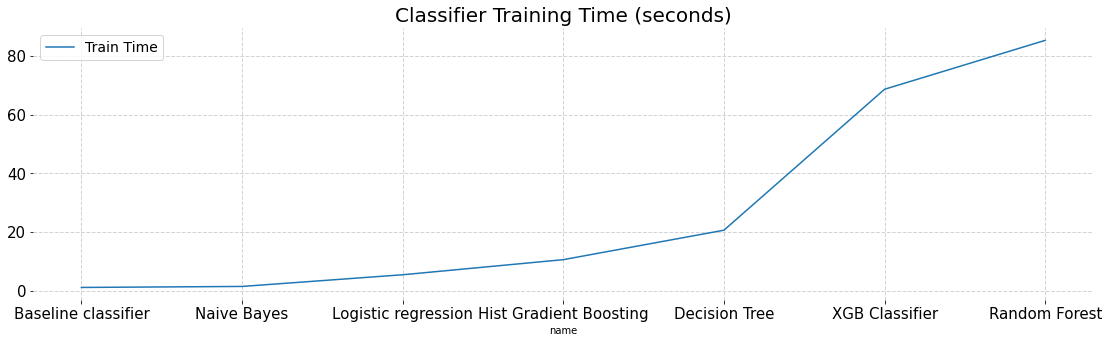

In [110]:
# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True) 
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line",
                                                               x="name", 
                                                               figsize=(19,5), 
                                                               title="Classifier Perf. Sorted by Val. Accuracy\n")
ax.legend(["Train Accuracy", "Val Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(True)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line",
                                         x="name", 
                                         figsize=(19,5), grid=True, 
                                         title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False) 

### Explanations via Feature Importance Scores [Tree Based Models]

Text(0.5, 0.98, 'Feature Importance for Tree Models. Top 30 Features.')

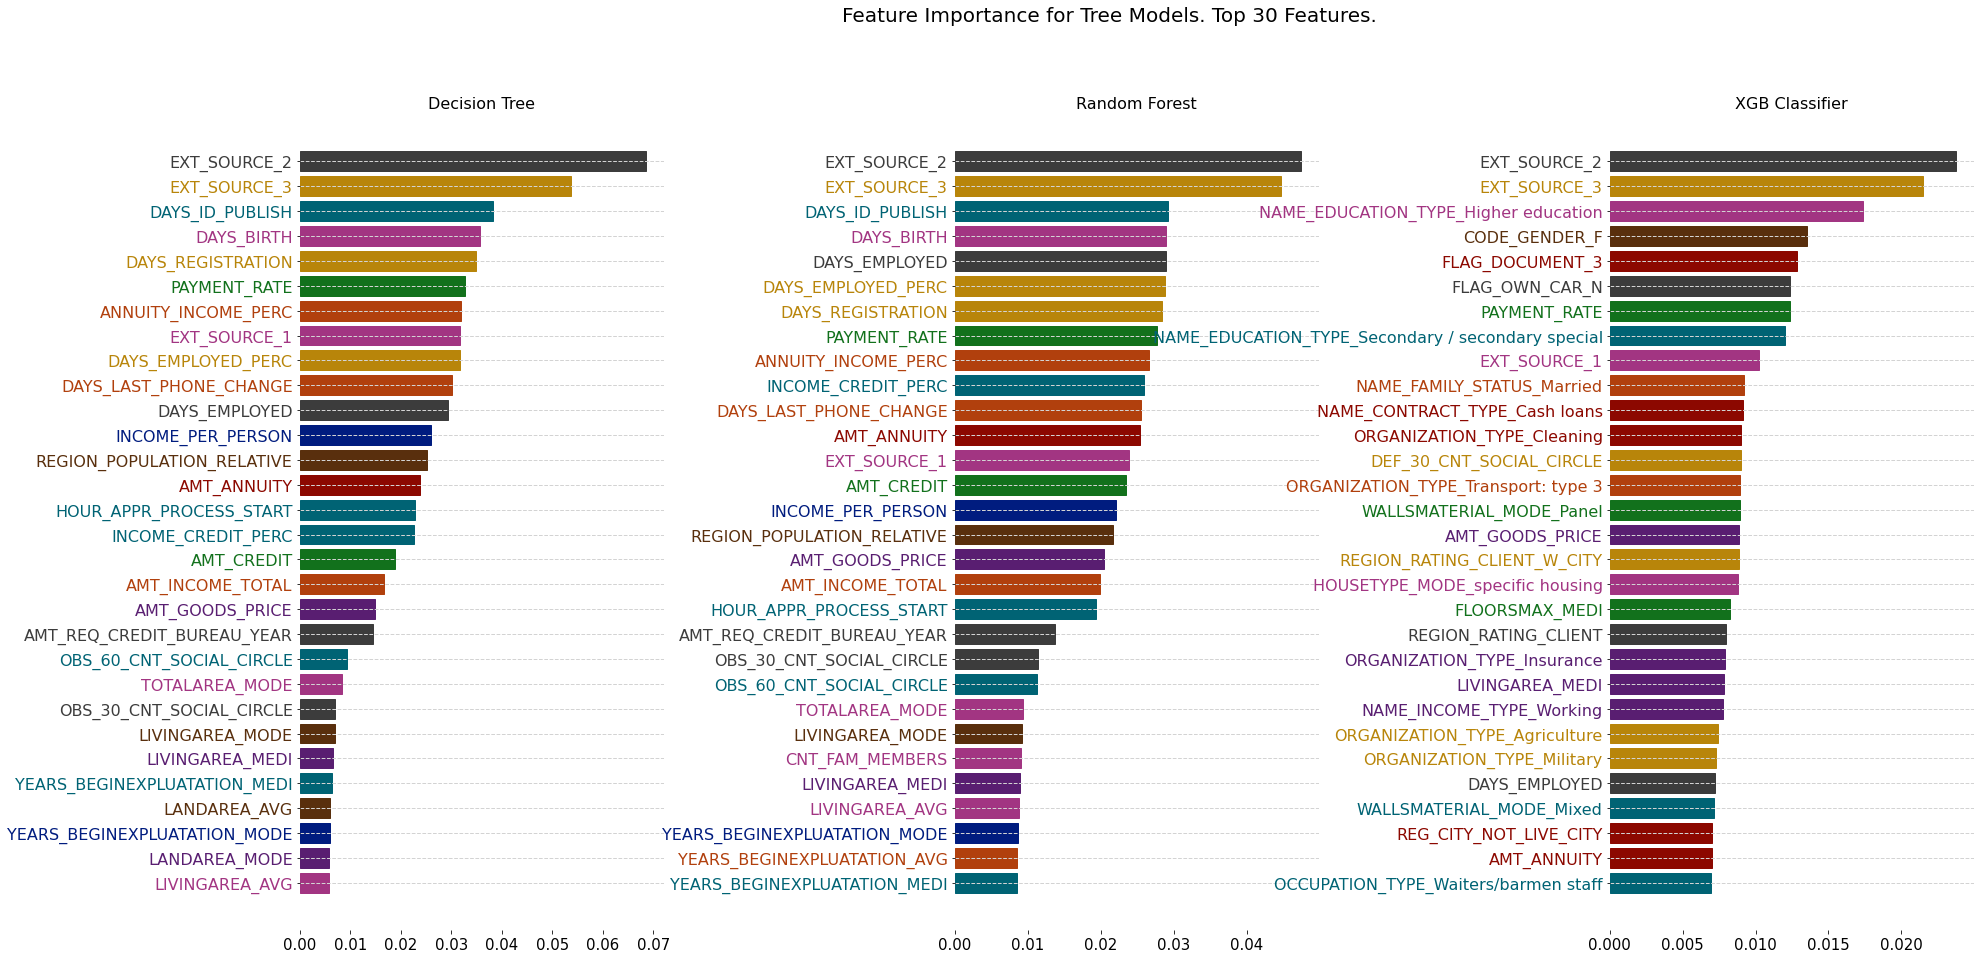

In [114]:
#@title

current_data = trainX_i

# Create array of tree based models and plot feature importance scores
tree_models = []
setup_plot()
color_list =  sns.color_palette("dark", len(current_data.columns)) 
top_x = 30 # number of x most important features to show


for model in trained_models:
    if hasattr(model["model"]["clf"], 'feature_importances_'): 
        tree_models.append({"name":model["name"], "fi": model["model"]["clf"].feature_importances_}) 

fig, axs = plt.subplots(1,3, figsize=(30, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
    feature_importance = tree_models[i]["fi"]
    indices = np.argsort(feature_importance)
    indices = indices[-top_x:]

    bars = axs[i].barh(range(len(indices)), feature_importance[indices], color='b', align='center') 
    axs[i].set_title( tree_models[i]["name"], fontweight="normal", fontsize=16)

    plt.sca(axs[i])
    plt.yticks(range(len(indices)), [current_data.columns[j] for j in indices], fontweight="normal", fontsize=16) 

  # print(len(plt.gca().get_yticklabels()), len(indices))
    for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
        ticklabel.set_color(color_list[indices[i]])  

    for i,bar in enumerate(bars):
        bar.set_color(color_list[indices[i]])
    plt.box(False)

plt.suptitle("Feature Importance for Tree Models. Top " + str(top_x) + " Features.", 
             fontsize=20, fontweight="normal")

### Features importance for linear mode  .coef_

In [116]:
trained_models[2]['model']

Pipeline(steps=[('scaler', StandardScaler()), ('clf', LogisticRegression())])

In [141]:
len(trained_models[2]['model'][1].coef_[0])

229

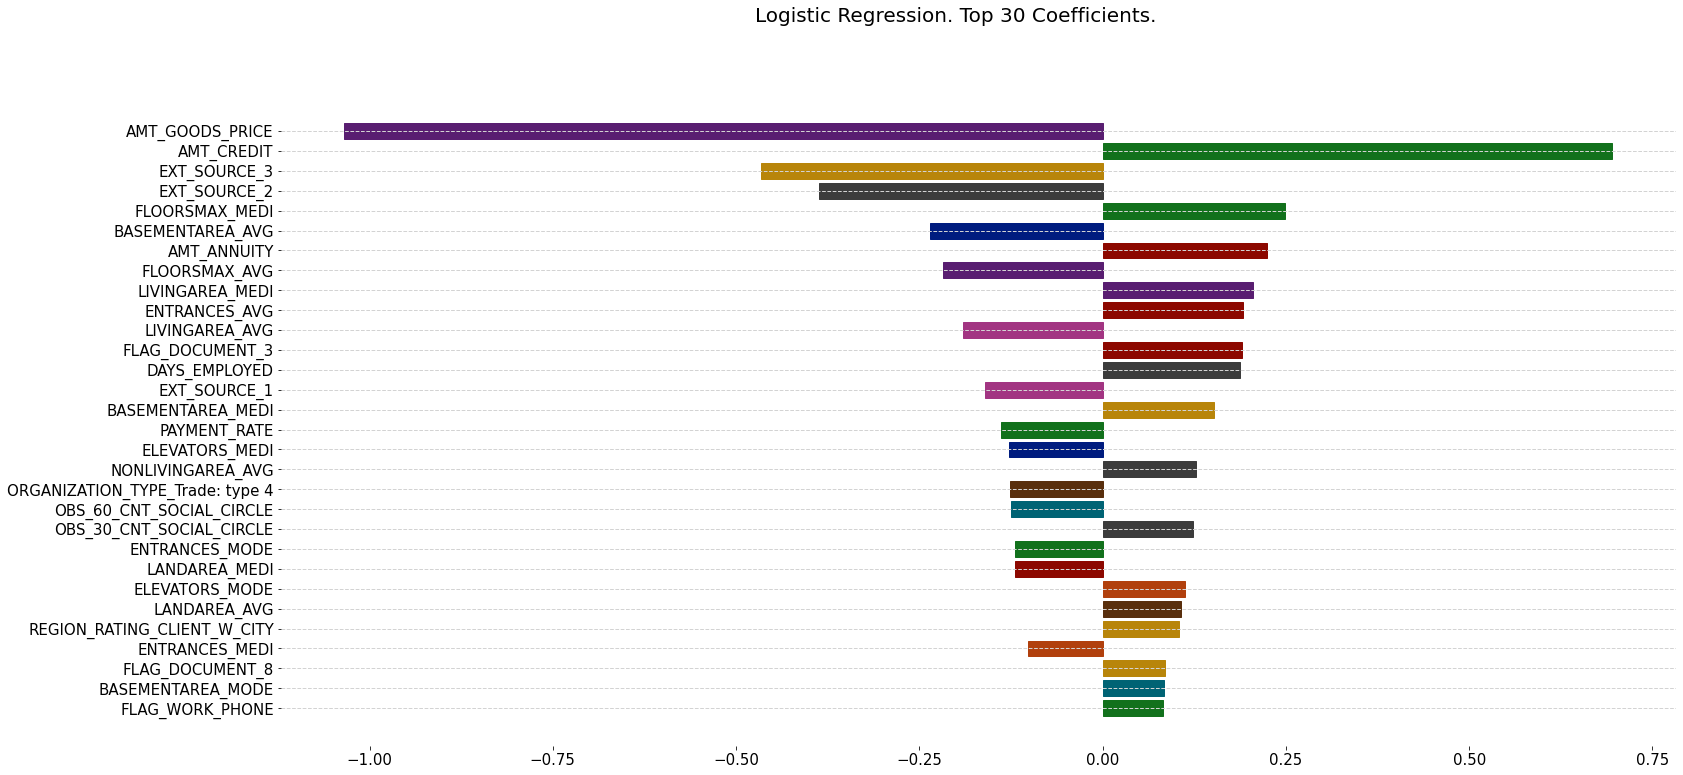

In [140]:
plt.figure(figsize=(25,12))


current_data = trainX_i

logistic_reg_coeff = trained_models[2]['model'][1].coef_[0]
color_list =  sns.color_palette("dark", len(current_data.columns)) 

top_x = 30
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(current_data.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
    bar.set_color(color_list[idx[:top_x][::-1][i]])
    plt.box(False) 
    
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", 
                        fontsize=20, 
                        fontweight="normal")

In [162]:
model_list = []

for i in range(len(trained_models)):
    #print(f"{trained_models[i]['name']} - AUC: {trained_models[i]['AUC']}")
    model_list.append(trained_models[i]['name'])
model_list

['Baseline classifier',
 'Naive Bayes',
 'Logistic regression',
 'Decision Tree',
 'Random Forest',
 'Hist Gradient Boosting',
 'XGB Classifier']

In [175]:
#models_list = [trained_models[i]['model']['clf'] for i in range(len(trained_models))]
#models_list

#models_list.pop(0)

DummyClassifier()

In [177]:
models_pipeline = models_list

In [186]:
## plot confusion matrix

from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

model_list = [trained_models[i]['name'] for i in range(len(trained_models))]
acc_list = [trained_models[i]['train_accuracy'] for i in range(len(trained_models))]
auc_list = [trained_models[i]['AUC'] for i in range(len(trained_models))]
models_pipeline = [trained_models[i]['model']['clf'] for i in range(len(trained_models))]
#models_pipeline = models_list

cm_list = []

for model in models_pipeline:
    with timer(f"running {model}"):   
        model.fit(X_train_i, y_train_i)
        y_pred = model.predict(X_test_i)
        acc_list.append(metrics.accuracy_score(y_test_i, y_pred))
        fpr, tpr, _thresholds = metrics.roc_curve(y_test_i, y_pred)
        auc_list.append(round(metrics.auc(fpr, tpr), 2))
        cm_list.append(confusion_matrix(y_test_i, y_pred))

running DummyClassifier() - done in 0s
running GaussianNB() - done in 2s
running LogisticRegression() - done in 5s
running DecisionTreeClassifier() - done in 20s
running RandomForestClassifier() - done in 84s
running HistGradientBoostingClassifier() - done in 9s
running XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) - done in 67s


In [190]:
cm_list_copy = cm_list
cm_list_copy

[array([[66437,     0],
        [ 6480,     0]]),
 array([[ 6268, 60169],
        [  323,  6157]]),
 array([[66349,    88],
        [ 6408,    72]]),
 array([[59988,  6449],
        [ 5325,  1155]]),
 array([[66432,     5],
        [ 6475,     5]]),
 array([[66335,   102],
        [ 6334,   146]]),
 array([[66156,   281],
        [ 6208,   272]])]

In [191]:
cm_list_copy.pop(0)

array([[66437,     0],
       [ 6480,     0]])

In [195]:
for i in range(len(cm_list_copy)):
    print(cm_list[i], "\n")
    

[[ 6268 60169]
 [  323  6157]] 

[[66349    88]
 [ 6408    72]] 

[[59988  6449]
 [ 5325  1155]] 

[[66432     5]
 [ 6475     5]] 

[[66335   102]
 [ 6334   146]] 

[[66156   281]
 [ 6208   272]] 



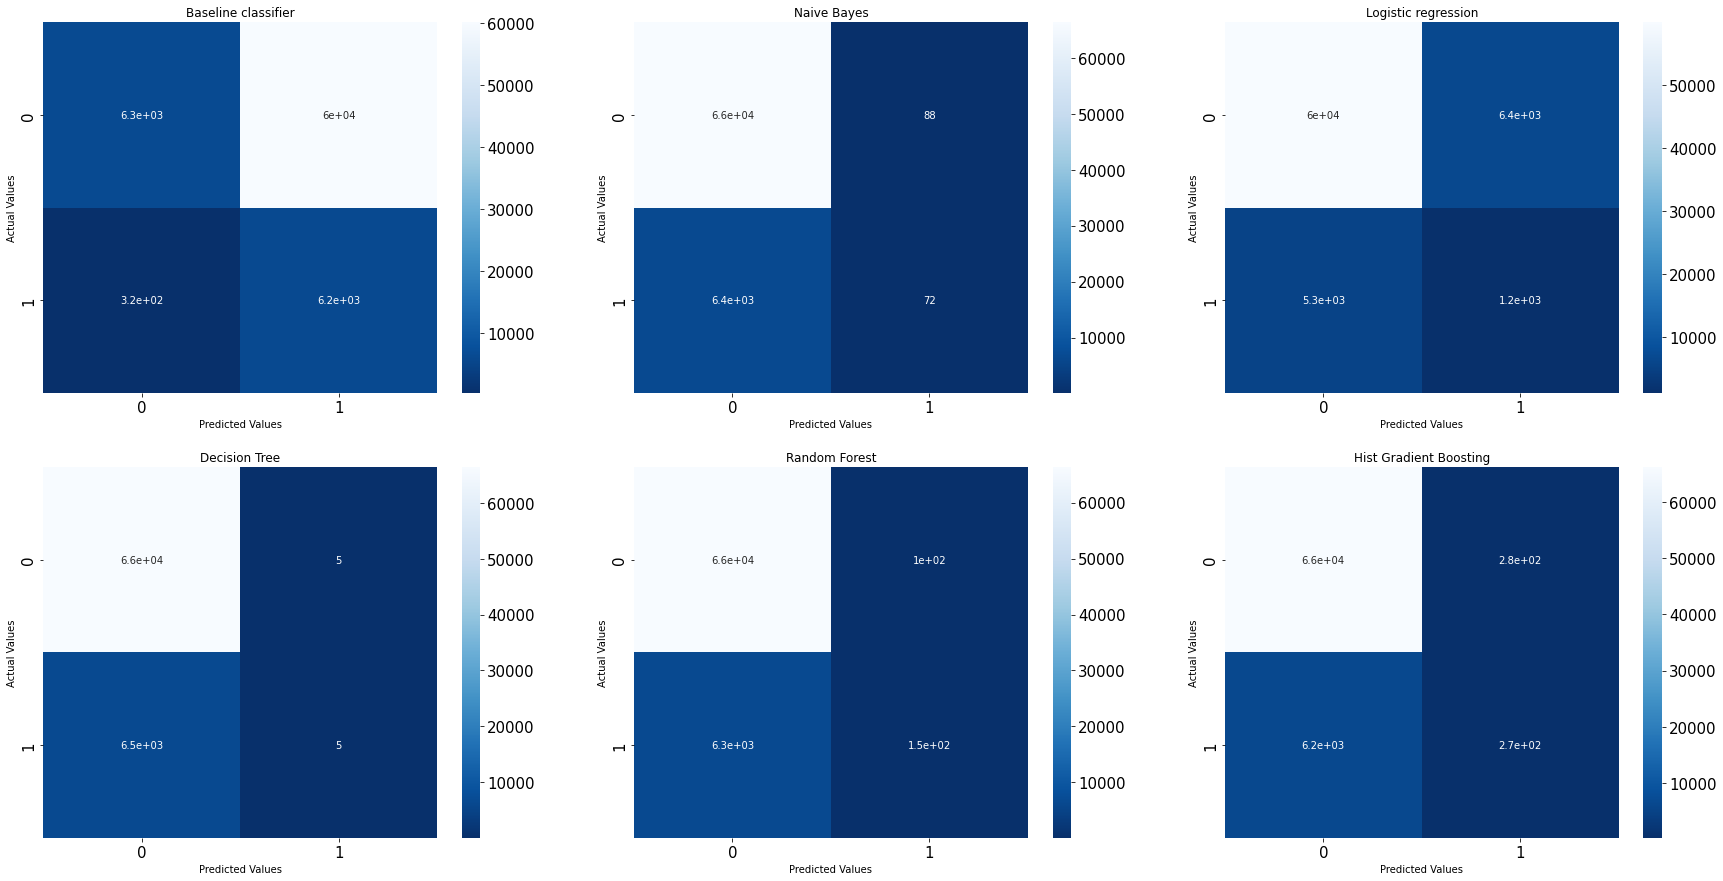

In [193]:
## plot confusion matrix
fig = plt.figure(figsize = (30, 15))
for i in range(len(cm_list_copy)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap= "Blues_r")
    cm_plot.set_xlabel("Predicted Values")
    cm_plot.set_ylabel("Actual Values")

In [199]:
model_list = [trained_models[i]['name'] for i in range(len(trained_models))]
acc_list = [trained_models[i]['train_accuracy'] for i in range(len(trained_models))]
precision_list = [trained_models[i]['precision'] for i in range(len(trained_models))]
recall_list = [trained_models[i]['recall'] for i in range(len(trained_models))]
f1_score_list = [trained_models[i]['AUC'] for i in range(len(trained_models))]
auc_list = [trained_models[i]['f1_score'] for i in range(len(trained_models))]
train_time_list = [trained_models[i]['train_time'] for i in range(len(trained_models))]


## accuracy and AUC
result_df = pd.DataFrame({"Model":model_list, 
                          "Accuracy":acc_list, 
                          "precision":precision_list,
                          "recall":recall_list,
                          "f1_score":f1_score_list,
                          "AUC": auc_list,
                         "train_time":train_time_list})
result_df

,Model,Accuracy,precision,recall,f1_score,AUC,train_time
0,Baseline classifier,0.912148,0.00,0.00,0.5000,0.0,1.193726
1,Naive Bayes,0.128812,0.00,0.00,0.5000,0.0,1.535120
2,Logistic regression,0.912195,0.00,0.00,0.5000,0.0,5.509589
3,Decision Tree,1.000000,15.52,5.76,0.5135,8.4,20.673752
4,Random Forest,0.999988,0.00,0.00,0.5000,0.0,85.282937
5,Hist Gradient Boosting,0.913829,0.00,0.00,0.5000,0.0,10.648631
6,XGB Classifier,0.919824,0.00,0.00,0.5000,0.0,68.641094


<p class="h3"; style="color:blue"> Utilisation du jeu de données avec plus de features  </p>

In [212]:
X_train_f.shape, X_test_f.shape, y_train_f.shape, y_test_f.shape

((170139, 273), (72917, 273), (170139, 1), (72917, 1))

In [213]:
X_train_f.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Unknown,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Unknown,EMERGENCYSTATE_MODE_Yes
24658,0.000000,0.016098,0.307309,0.176662,0.274972,0.403507,0.633188,0.934792,0.766399,0.435737,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
75658,0.105263,0.007335,0.031371,0.050979,0.023569,0.410033,0.622215,0.925357,0.643013,0.324163,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10333,0.000000,0.004832,0.101124,0.098310,0.102132,0.403507,0.894581,0.973258,0.825977,0.892872,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
35355,0.000000,0.004081,0.060815,0.073658,0.054994,0.486697,0.407961,0.655147,0.712535,0.799639,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
114083,0.000000,0.019853,0.269663,0.237837,0.270483,0.702852,0.572444,0.905817,0.895586,0.753786,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [214]:
trained_models_moreFeatures = [] #  keep track of all details for models we train

for model in models:
    with timer(f"running {model}"):
        model_details = train_model(model, X_train_f, X_test_f, y_train_f, y_test_f) 
        trained_models_moreFeatures.append(model_details)

running {'name': 'Baseline classifier', 'clf': DummyClassifier()} - done in 3s
running {'name': 'Naive Bayes', 'clf': GaussianNB()} - done in 5s
running {'name': 'Logistic regression', 'clf': LogisticRegression()} - done in 7s
running {'name': 'Decision Tree', 'clf': DecisionTreeClassifier()} - done in 37s
running {'name': 'Random Forest', 'clf': RandomForestClassifier()} - done in 127s
running {'name': 'Hist Gradient Boosting', 'clf': HistGradientBoostingClassifier()} - done in 13s
running {'name': 'XGB Classifier', 'clf': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, ma

In [235]:
def trained_models_results(trained_models):
    model_list = [trained_models[i]['name'] for i in range(len(trained_models))]
    acc_list = [trained_models[i]['train_accuracy'] for i in range(len(trained_models))]
    precision_list = [trained_models[i]['precision'] for i in range(len(trained_models))]
    recall_list = [trained_models[i]['recall'] for i in range(len(trained_models))]
    f1_score_list = [trained_models[i]['f1_score'] for i in range(len(trained_models))]
    auc_list = [trained_models[i]['AUC'] for i in range(len(trained_models))]
    train_time_list = [trained_models[i]['train_time'] for i in range(len(trained_models))]


    ## accuracy and AUC
    result_df = pd.DataFrame({"Model":model_list, 
                          "Accuracy":acc_list, 
                          "precision":precision_list,
                          "recall":recall_list,
                          "f1_score":f1_score_list,
                          "AUC": auc_list,
                         "train_time":train_time_list})
    
    result_df
    
    return result_df.sort_values(by='AUC', ascending=False)

In [215]:
# visualize accuracy and run time
def visualizing_models_accuracy(trained_models):
    setup_plot()
    model_df = pd.DataFrame(trained_models)
    model_df.sort_values("test_accuracy", inplace=True) 
    ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line",
                                                               x="name", 
                                                               figsize=(19,5), 
                                                               title="Classifier Perf. Sorted by Val. Accuracy\n")
    ax.legend(["Train Accuracy", "Val Accuracy"])
    for p in ax.patches:
        ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

    ax.title.set_size(20)
    plt.box(True)

    model_df.sort_values("train_time", inplace=True)
    ax= model_df[["train_time","name"]].plot(kind="line",
                                         x="name", 
                                         figsize=(19,5), grid=True, 
                                         title="Classifier Training Time (seconds)")
    ax.title.set_size(20)
    ax.legend(["Train Time"])
    plt.box(False) 

In [220]:
#trained_models_results(trained_models=trained_models_moreFeatures)

In [217]:
#visualizing_models_accuracy(trained_models=trained_models_moreFeatures)

<p class="h3"; style="color:blue"> Gestion du problème de déséquilibre de classe  </p>


### Utilisation des méthodes de rééchantillonnage 

Nous allons modifier l’ensemble de données utilisé avant d’entraîner le modèle prédictif afin d’avoir des données plus équilibrées. Cette stratégie est appelée rééchantillonnage et il existe deux méthodes principales que vous pouvez utiliser pour égaliser les classes :  Le **sur-échantillonnage** (Oversampling) et le **sous-échantillonnage** (Undersampling).

- Les `méthodes d’Oversampling` fonctionnent en augmentant le nombre d’observations de la (des) classe(s) minoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.

- Les `méthodes d’Undersampling` fonctionnent en diminuant le nombre d’observations de la  (des) classe(s) majoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.


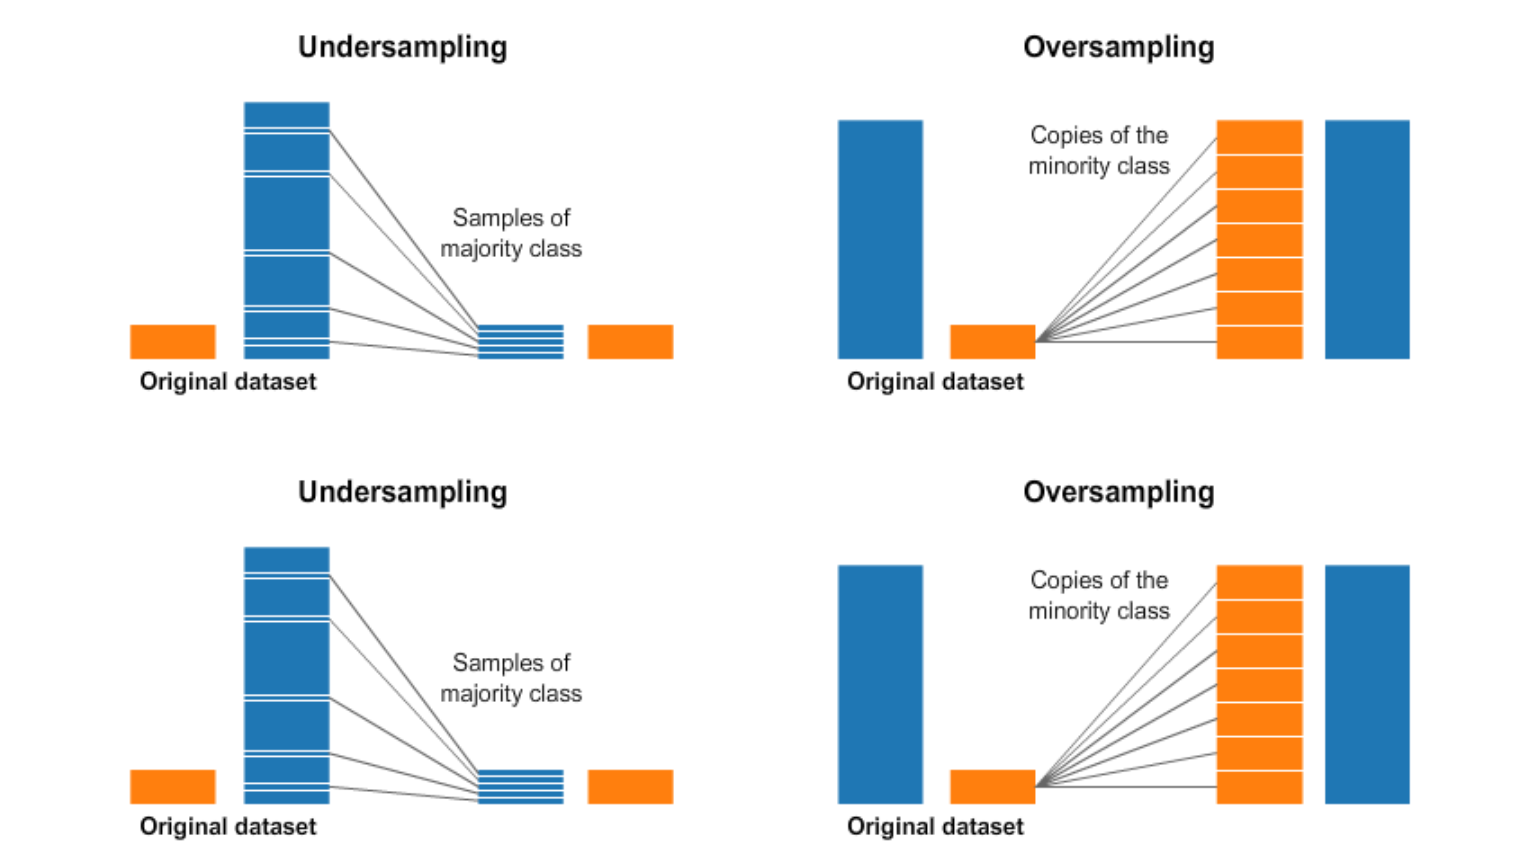

In [200]:
#y_train
X_train_i.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Unknown,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Unknown,EMERGENCYSTATE_MODE_Yes
24658,0.000000,0.016098,0.307309,0.176662,0.274972,0.403507,0.633188,0.934792,0.766399,0.435737,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
75658,0.105263,0.007335,0.031371,0.050979,0.023569,0.410033,0.622215,0.925357,0.643013,0.324163,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10333,0.000000,0.004832,0.101124,0.098310,0.102132,0.403507,0.894581,0.973258,0.825977,0.892872,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
35355,0.000000,0.004081,0.060815,0.073658,0.054994,0.486697,0.407961,0.655147,0.712535,0.799639,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
114083,0.000000,0.019853,0.269663,0.237837,0.270483,0.702852,0.572444,0.905817,0.895586,0.753786,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [203]:
from sklearn.utils import resample

X_train_resampling = X_train_i 
X_train_resampling['TARGET'] = y_train_i

#X_train_resampling_i['TARGET'].value_counts()

minority = X_train_resampling[X_train_resampling["TARGET"] == 1]
majority = X_train_resampling[X_train_resampling["TARGET"] == 0]

#### Méthode Sur-echantillonage

In [204]:
# Résolution du problème de déséquilibre de classe : Méthode de sur-échantillonnage de la classe minoritaire

minority_upsampled = resample(minority, replace = True, n_samples = len(majority), random_state=42)
upsampled = pd.concat([majority, minority_upsampled])

# Vérification
#upsampled['TARGET'].value_counts(normalize = False)

# Données d'entraînement sur la base la méthode de sur-échantillonnage de la classe minoritaire
X_train_up_i = upsampled.drop('TARGET', axis = 1)
y_train_up_i = upsampled['TARGET']

#### Méthode Sous-echantillonage

In [205]:
# Résolution du problème de déséquilibre de classe : Méthode de sous-échantillonnage de la classe majoritaire
majority_downsampled = resample(majority, replace=False, n_samples = len(minority), random_state = 42)
downsampled = pd.concat([minority, majority_downsampled])

# Vérification
#downsampled['TARGET'].value_counts(normalize = False)

# Données d'entraînement sur la base la méthode de sous-échantillonnage de la classe majoritaire
X_train_down_i = downsampled.drop('TARGET', axis=1)
y_train_down_i = downsampled['TARGET']

In [222]:
# Méthode de sous-echantillonage sur jeu de données final

X_train_resampling = X_train_f 
X_train_resampling['TARGET'] = y_train_f

minority = X_train_resampling[X_train_resampling["TARGET"] == 1]
majority = X_train_resampling[X_train_resampling["TARGET"] == 0]

# Résolution du problème de déséquilibre de classe : Méthode de sous-échantillonnage de la classe majoritaire
majority_downsampled = resample(majority, replace=False, n_samples = len(minority), random_state = 42)
downsampled = pd.concat([minority, majority_downsampled])

# Données d'entraînement sur la base la méthode de sous-échantillonnage de la classe majoritaire
X_train_down_f = downsampled.drop('TARGET', axis=1)
y_train_down_f = downsampled['TARGET']

### Re-entrainements des modèle avec jeu de donnée équilibré sur dataset initial

In [237]:
trained_models_balanced_i = [] #  keep track of all details for models we train

for model in models:
    with timer(f"running {model}"):
        model_details = train_model(model, X_train_down_i, X_test_i, y_train_down_i, y_test_i) 
        trained_models_balanced_i.append(model_details)

running {'name': 'Baseline classifier', 'clf': DummyClassifier()} - done in 1s
running {'name': 'Naive Bayes', 'clf': GaussianNB()} - done in 1s
running {'name': 'Logistic regression', 'clf': LogisticRegression()} - done in 1s
running {'name': 'Decision Tree', 'clf': DecisionTreeClassifier()} - done in 2s
running {'name': 'Random Forest', 'clf': RandomForestClassifier()} - done in 14s
running {'name': 'Hist Gradient Boosting', 'clf': HistGradientBoostingClassifier()} - done in 2s
running {'name': 'XGB Classifier', 'clf': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_l

In [238]:
result_df_balanced_i = trained_models_results(trained_models=trained_models_balanced_i)
result_df_balanced_i

,Model,Accuracy,precision,recall,f1_score,AUC,train_time
2,Logistic regression,0.686292,24.15,36.57,29.09,0.6268,0.720224
4,Random Forest,1.000000,13.55,23.55,17.20,0.5444,9.080997
5,Hist Gradient Boosting,0.734094,22.73,8.70,12.59,0.5291,2.023423
6,XGB Classifier,0.845420,25.00,0.77,1.50,0.5027,11.227493
1,Naive Bayes,0.543755,50.00,0.02,0.03,0.5001,0.206953
0,Baseline classifier,0.500000,0.00,0.00,0.00,0.5000,0.202661
3,Decision Tree,1.000000,8.69,57.89,15.11,0.4927,1.749125


### Re-entrainements des modèle avec jeu de donnée équilibré sur dataset final

In [223]:
trained_models_balanced_f = [] #  keep track of all details for models we train

for model in models:
    with timer(f"running {model}"):
        model_details = train_model(model, X_train_down_f, X_test_f, y_train_down_f, y_test_f) 
        trained_models_balanced_f.append(model_details)

running {'name': 'Baseline classifier', 'clf': DummyClassifier()} - done in 0s
running {'name': 'Naive Bayes', 'clf': GaussianNB()} - done in 2s
running {'name': 'Logistic regression', 'clf': LogisticRegression()} - done in 1s
running {'name': 'Decision Tree', 'clf': DecisionTreeClassifier()} - done in 3s
running {'name': 'Random Forest', 'clf': RandomForestClassifier()} - done in 19s
running {'name': 'Hist Gradient Boosting', 'clf': HistGradientBoostingClassifier()} - done in 4s
running {'name': 'XGB Classifier', 'clf': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_l

In [236]:
result_df_balanced_f = trained_models_results(trained_models=trained_models_balanced_f)
result_df_balanced_f

,Model,Accuracy,precision,recall,f1_score,AUC,train_time
5,Hist Gradient Boosting,0.773801,18.25,35.11,24.02,0.5989,3.259215
4,Random Forest,1.000000,11.54,74.09,19.97,0.5935,13.028679
6,XGB Classifier,0.878236,10.64,83.87,18.88,0.5757,15.459811
2,Logistic regression,0.693417,37.30,8.18,13.42,0.5342,0.719950
1,Naive Bayes,0.555864,50.00,0.02,0.03,0.5001,0.277565
0,Baseline classifier,0.500000,0.00,0.00,0.00,0.5000,0.151067
3,Decision Tree,1.000000,7.08,46.54,12.29,0.4347,2.963696


<p class="h3"; style="color:blue"> Optimisation des hyperparametres- Tunning Hyper-parameters  </p>

#### Fine Tuning LogisticRegression model

In [243]:
# Different hyperparameters for LogisticRegression model
from sklearn.model_selection import GridSearchCV

# Create a hyper-parameters tunning for LogisticRegression 
log_reg_grid = {"penalty" : ["l1", "l2"],
                "C": np.logspace(-4, 4, 30),}
                #"solver": ["liblinear", "library", "newton-cg", "sag", "saga" , "lbfgs"]}


# Setup grid hyerperparatmeter search for LogisticRegression 
gs_log_reg_i = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit our grid hyperparameters search model

with timer("Log_reg model fine_tuning on inial data balanced"):                
    gs_log_reg_i.fit(X_train_down_i, y_train_down_i)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Log_reg model fine_tuning on inial data balanced - done in 68s


In [244]:
gs_log_reg_i

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             verbose=True)

In [245]:
# Check the best hyperparameters
gs_log_reg_i.best_params_

{'C': 0.7278953843983146, 'penalty': 'l2'}

In [246]:
evaluation(model=gs_log_reg_i, X_test=X_test_i, y_test=y_test_i)

AUC : 0.6822

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.68      0.80     66437
           1       0.17      0.68      0.28      6480

    accuracy                           0.68     72917
   macro avg       0.56      0.68      0.54     72917
weighted avg       0.89      0.68      0.75     72917

Evaluation metrics:
 {'accuracy': 68.36, 'precision': 17.35, 'recall': 68.04, 'f1_score': 27.65}


Confusion Matrix
         pred_0  pred_1
test_0   45439   20998
test_1    2071    4409


In [249]:
# Different hyperparameters for LogisticRegression model
from sklearn.model_selection import GridSearchCV

# Create a hyper-parameters tunning for LogisticRegression 
log_reg_grid = {"penalty" : ["l1", "l2"],
                "C": np.logspace(-4, 4, 30),}
                #"solver": ["liblinear", "library", "newton-cg", "sag", "saga" , "lbfgs"]}


# Setup grid hyerperparatmeter search for LogisticRegression 
gs_log_reg_f = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit our grid hyperparameters search model

with timer("\tLog_reg model fine_tuning on final data balanced"):                
    gs_log_reg_f.fit(X_train_down_f, y_train_down_f)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
	Log_reg model fine_tuning on final data balanced - done in 79s


In [250]:
gs_log_reg_f

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             verbose=True)

In [251]:
# Check the best hyperparameters
gs_log_reg_f.best_params_

{'C': 9.236708571873866, 'penalty': 'l2'}

In [252]:
evaluation(model=gs_log_reg_f, X_test=X_test_f, y_test=y_test_f)

AUC : 0.6866

Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     66437
         1.0       0.18      0.68      0.28      6480

    accuracy                           0.69     72917
   macro avg       0.57      0.69      0.54     72917
weighted avg       0.89      0.69      0.76     72917

Evaluation metrics:
 {'accuracy': 69.09, 'precision': 17.74, 'recall': 68.15, 'f1_score': 28.15}


Confusion Matrix
         pred_0  pred_1
test_0   45961   20476
test_1    2064    4416


#### Fine Tuning HistGradientBoostingClassifier model

In [241]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

hgb_clf_params = {'learning_rate': [1e-1, 2e-1, 3e-1],
          'max_depth': [2, 4, 5],
          'min_samples_leaf': [30, 31, 32],
          'max_iter': [100, 150]
          }


# Setup random hyperparameter search for HistGradientBoostingClassifier
gs_hgb_clf_f = GridSearchCV(HistGradientBoostingClassifier(),
                                param_grid=gb_params,
                                cv=4,
                                verbose=True)

gs_hgb_clf_f.fit(X_train_down_f, y_train_down_f)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


GridSearchCV(cv=4, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 4, 5], 'max_iter': [100, 150],
                         'min_samples_leaf': [30, 31, 32]},
             verbose=True)

In [247]:
# Check the best hyperparameters
gs_hgb_clf_f.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'max_iter': 150, 'min_samples_leaf': 31}

In [248]:
evaluation(model=gs_hgb_clf_f, X_test=X_test_f, y_test=y_test_f)

AUC : 0.7018

Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     66437
         1.0       0.19      0.70      0.29      6480

    accuracy                           0.70     72917
   macro avg       0.57      0.70      0.55     72917
weighted avg       0.89      0.70      0.76     72917

Evaluation metrics:
 {'accuracy': 70.02, 'precision': 18.61, 'recall': 70.39, 'f1_score': 29.44}


Confusion Matrix
         pred_0  pred_1
test_0   46493   19944
test_1    1919    4561


<p class="h3"; style="color:blue"> Best Final Model - HistGradientBoostingClassifier </p>

In [255]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

def cf_matrix_roc_auc(y_true, y_pred, y_pred_proba, size):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix using
    a Seaborn heatmap visualization + ROC Curve.
    '''
    plt.style.use('default')
    
    fig = plt.figure(figsize=size)
    
    roc_auc = roc_auc_score(y_true, y_pred)
    
  
    #plt.subplot(221)
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    cf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues_r')
    plt.tick_params(axis='both', which='major', labelsize=10, 
                    labelbottom = False, bottom=False, top = False, labeltop=True)


    #plt.subplot(222)
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba[:,1])    #pour la courbe ROC utilisation de la proba d'être 1
    plt.plot(fpr, tpr, color='blue', linewidth=2, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()

In [253]:
# Train the model
from sklearn.ensemble import HistGradientBoostingClassifier

# train a Random Forest model on the training set
HistGB_balanced_model_f = HistGradientBoostingClassifier(learning_rate=0.1,
                                                          max_depth=4,
                                                          max_iter=150,
                                                          min_samples_leaf=31
                                                         )

#Fitting our model
HistGB_balanced_model_f.fit(X_train_down_f, y_train_down_f)
print (HistGB_balanced_model_f)

HistGradientBoostingClassifier(max_depth=4, max_iter=150, min_samples_leaf=31)


In [254]:
HistGB_balanced_model_f

HistGradientBoostingClassifier(max_depth=4, max_iter=150, min_samples_leaf=31)

In [257]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 

y_pred = HistGB_balanced_model_f.predict(X_test_f)
y_pred_proba = HistGB_balanced_model_f.predict_proba(X_test_f)

roc_auc = roc_auc_score(y_test_f, y_pred)  #on se base sur la probabilité d'être en défaut de paiement
print('AUC : %0.4f' %roc_auc)

AUC : 0.7013


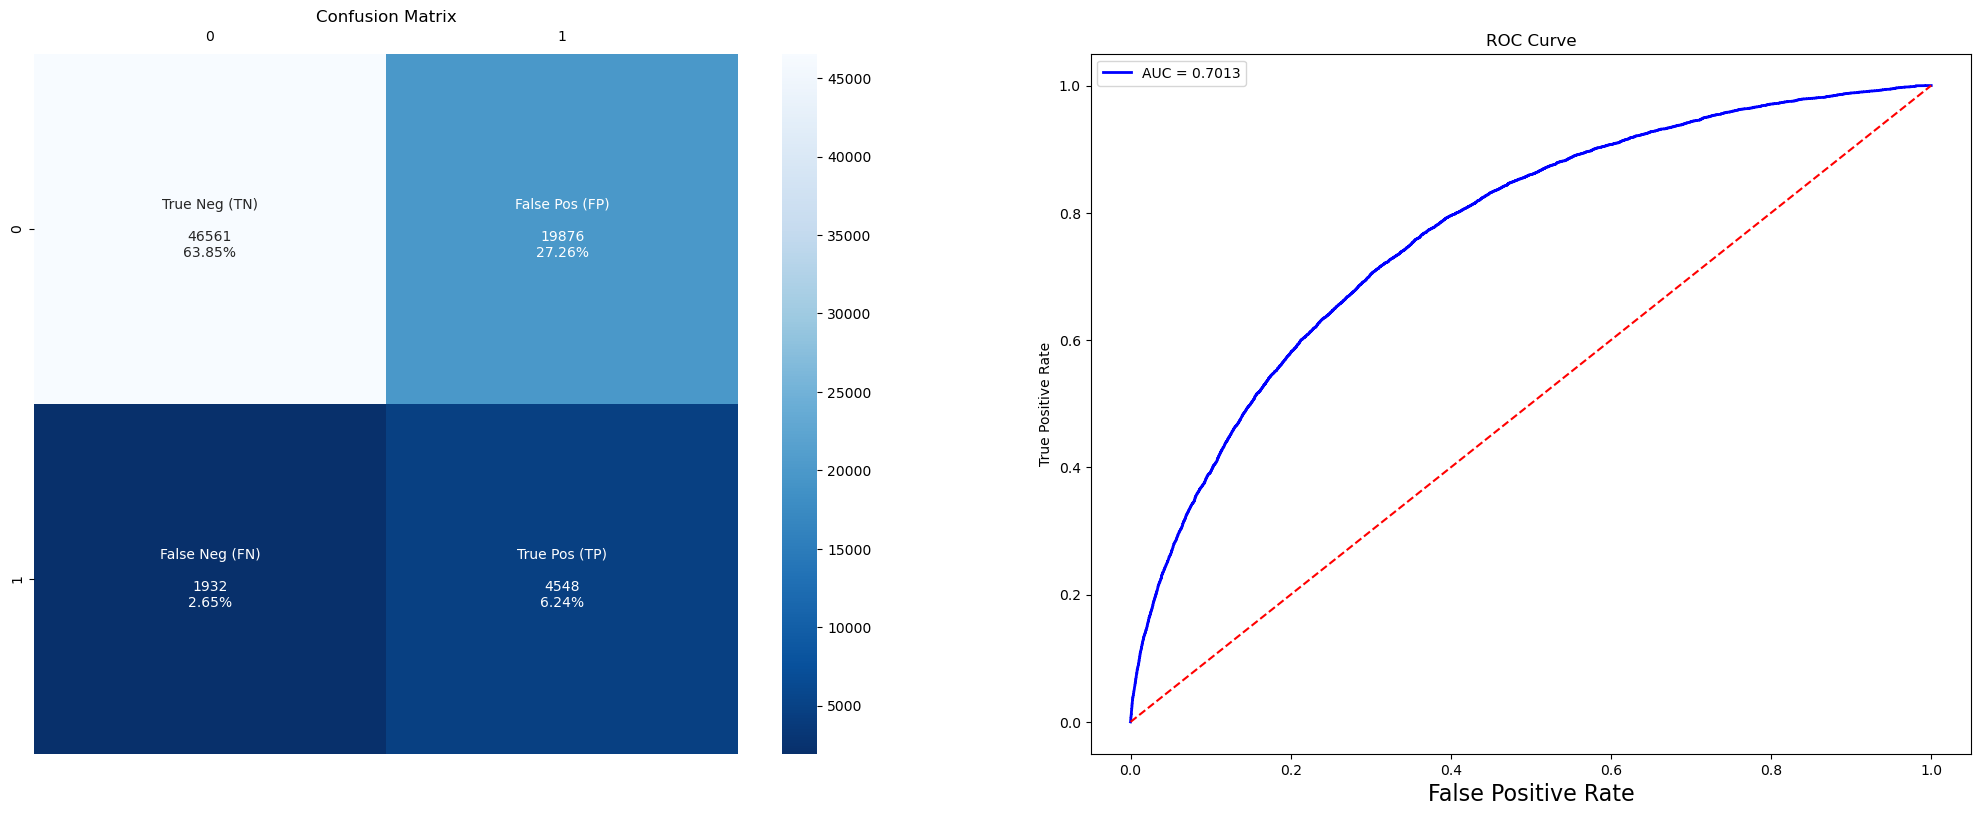

In [258]:
cf_matrix_roc_auc(y_test_f, y_pred, y_pred_proba, (25,20))

In [264]:
#np.linspace(0.1, 1, 10)

In [287]:
from sklearn.model_selection import learning_curve

def tunned_learning_curve(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    with timer("Model learning"): 
        N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                              cv=5, scoring="accuracy",
                                              train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(10, 5))
    plt.plot(N, train_score.mean(axis=1), label="train score")
    plt.plot(N, val_score.mean(axis=1), label="validation score")
    plt.legend(loc='best', title='accuracy')  # https://www.statology.org/matplotlib-legend-position/ 
                                                                                    #loc=lower right

Model learning - done in 45s


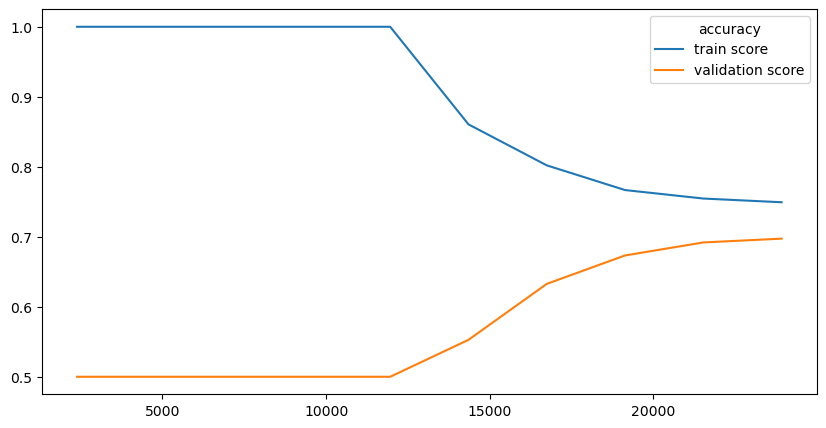

In [288]:
tunned_learning_curve(model=HistGB_balanced_model_f,
                      X_train=X_train_down_f, 
                      y_train=y_train_down_f,
                      X_test=X_test_f)

In [ ]:
#metrics.get_scorer_names()

<p class="h3"; style="color:blue"> Pipeline - Putting All_together </p>

In [325]:
pd.set_option('display.max_column', 200)

df_final.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_test,is_train,p_SK_ID_PREV,p_AMT_ANNUITY,p_AMT_APPLICATION,p_AMT_CREDIT,p_AMT_DOWN_PAYMENT,p_AMT_GOODS_PRICE,p_HOUR_APPR_PROCESS_START,p_NFLAG_LAST_APPL_IN_DAY,p_RATE_DOWN_PAYMENT,p_RATE_INTEREST_PRIMARY,p_RATE_INTEREST_PRIVILEGED,p_DAYS_DECISION,p_SELLERPLACE_AREA,p_CNT_PAYMENT,p_DAYS_FIRST_DRAWING,p_DAYS_FIRST_DUE,p_DAYS_LAST_DUE_1ST_VERSION,p_DAYS_LAST_DUE,p_DAYS_TERMINATION,p_NFLAG_INSURED_ON_APPROVAL,b_SK_ID_BUREAU,b_DAYS_CREDIT,b_CREDIT_DAY_OVERDUE,b_DAYS_CREDIT_ENDDATE,b_DAYS_ENDDATE_FACT,b_AMT_CREDIT_MAX_OVERDUE,b_CNT_CREDIT_PROLONG,b_AMT_CREDIT_SUM,b_AMT_CREDIT_SUM_DEBT,b_AMT_CREDIT_SUM_LIMIT,b_AMT_CREDIT_SUM_OVERDUE,b_DAYS_CREDIT_UPDATE,b_AMT_ANNUITY,b_buro_count,i_SK_ID_PREV,i_NUM_INSTALMENT_VERSION,i_NUM_INSTALMENT_NUMBER,i_DAYS_INSTALMENT,i_DAYS_ENTRY_PAYMENT,i_AMT_INSTALMENT,i_AMT_PAYMENT,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,cc_bal_SK_ID_PREV,cc_bal_MONTHS_BALANCE,cc_bal_AMT_BALANCE,cc_bal_AMT_CREDIT_LIMIT_ACTUAL,cc_bal_AMT_DRAWINGS_ATM_CURRENT,cc_bal_AMT_DRAWINGS_CURRENT,cc_bal_AMT_DRAWINGS_OTHER_CURRENT,cc_bal_AMT_DRAWINGS_POS_CURRENT,cc_bal_AMT_INST_MIN_REGULARITY,cc_bal_AMT_PAYMENT_CURRENT,cc_bal_AMT_PAYMENT_TOTAL_CURRENT,cc_bal_AMT_RECEIVABLE_PRINCIPAL,cc_bal_AMT_RECIVABLE,cc_bal_AMT_TOTAL_RECEIVABLE,cc_bal_CNT_DRAWINGS_ATM_CURRENT,cc_bal_CNT_DRAWINGS_CURRENT,cc_bal_CNT_DRAWINGS_OTHER_CURRENT,cc_bal_CNT_DRAWINGS_POS_CURRENT,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,

In [324]:
print_proportion_nan(df_final)

Taille du jeu de données :  (356255, 192)
 --> Proportion de NaN : 27.03%


In [332]:
def semi_preprocessing(df) :
    
    with timer("Preparing data for modeling "):
        df = new_features_creation(df)
        #df = nan_imputation(df)
        #df = removing_outliers(df)
        #df = features_encoding(df)
          
    ignore_features = ['is_train', 'is_test', 'SK_ID_CURR', 'TARGET']
    relevant_features = [col for col in df.columns if col not in ignore_features]
    
    trainX = df[df['is_train'] == 1][relevant_features + ['TARGET']]
    testX = df[df['is_test'] == 1][relevant_features]
    
    trainy = trainX['TARGET']
    
    return trainX, testX, trainy

In [333]:
trainX, testX, trainy = semi_preprocessing(df_final)

Preparing data for modeling  - done in 2s


In [334]:
num_vars = trainX.drop(columns=['TARGET'], axis=1).select_dtypes(exclude=['object']).columns
print(len(num_vars))
#num_vars   

177


In [336]:
cat_vars = trainX.drop(columns=['TARGET'], axis=1).select_dtypes(include=['object']).columns
#cat_vars = trainX.drop('SK_ID_CURR', axis=1).drop(columns=num_vars, axis=1).columns
print(len(cat_vars))
#cat_vars

16


In [386]:
from sklearn.model_selection import train_test_split

X = trainX.drop("TARGET", axis=1)
y = trainy.values.reshape(-1,1)

seed = np.random.seed(42)

# Split. into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                   random_state=seed)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 193), (92254, 193), (215257, 1), (92254, 1))

In [387]:
# Méthode de sous-echantillonage sur jeu de données final

X_train_resampling = X_train
X_train_resampling['TARGET'] = y_train

minority = X_train_resampling[X_train_resampling["TARGET"] == 1]
majority = X_train_resampling[X_train_resampling["TARGET"] == 0]

majority_downsampled = resample(majority, replace=False, n_samples = len(minority), random_state = 42)
downsampled = pd.concat([minority, majority_downsampled])

X_train_down = downsampled.drop('TARGET', axis=1)
y_train_down = downsampled['TARGET']

In [317]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Default values 
default_estimator = RandomForestClassifier()
default_impute_num= SimpleImputer(strategy="median")
default_impute_cat= SimpleImputer(strategy="constant", fill_value="Unknown")
default_scaler = StandardScaler()

def build_pipeline(algo_ml=default_estimator, 
                   impute_num= default_impute_num,
                   impute_cat= default_impute_cat,
                   scaler= default_scaler):
    
    # Pipeline de transformation des variables numériques 
    numeric_transformer = make_pipeline((impute_num),
                                        (scaler))
    
    # Pipeline de transformation des variables catégorielles 
    categorical_transformer = make_pipeline((impute_cat),
                                            (OneHotEncoder(handle_unknown="ignore")))
    
    #Combinaison des étapes
    preprocessor = ColumnTransformer(
        transformers = [('num', numeric_transformer, num_vars),
                        ('cat', categorical_transformer, cat_vars),
                        #('cat_bin', cat_binary_transfromer, cat_vars_bin)
                       ])
    
    # Piline final Machine Learning 
    model = Pipeline(steps=[('preprocessing', preprocessor),
                            ('estimator', (algo_ml))
                           ])
    return model

In [388]:
num_vars = df_final.drop(columns=ignore_columns, axis=1).select_dtypes(exclude=['object']).columns
cat_vars = df_final.drop(columns=ignore_columns, axis=1).select_dtypes(include=['object']).columns
# Parameters values 
estimator = HistGradientBoostingClassifier(learning_rate=0.1,
                                           max_depth=4,
                                           max_iter=150,
                                           min_samples_leaf=31)

impute_num= SimpleImputer(strategy="median")
impute_cat= SimpleImputer(strategy="constant", fill_value="Unknown")
scaler = MinMaxScaler()

HGB_clf_pipe_f = build_pipeline(algo_ml=estimator, 
                   impute_num= impute_num,
                   impute_cat= impute_cat,
                   scaler= scaler)

In [389]:
HGB_clf_pipe_f

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBL...
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('estimator',
                 HistGradientBoostingClassifier(max_depth=4, max_iter=150,
                                                min_samples_leaf=31))])

In [392]:
# Entraîner le pipeline modèle 
HGB_clf_pipe_f.fit(X_train_down, y_train_down)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBL...
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('estimator',
                 HistGradientBoostingClassifier(max_depth=4, max_iter=150,
                                                min_samples_leaf=31))])

In [393]:
evaluation(model=HGB_clf_pipe_f, X_test=X_test, y_test=y_test)

AUC : 0.7011

Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     84841
         1.0       0.17      0.70      0.27      7413

    accuracy                           0.70     92254
   macro avg       0.57      0.70      0.54     92254
weighted avg       0.90      0.70      0.77     92254

Evaluation metrics:
 {'accuracy': 70.25, 'precision': 17.05, 'recall': 69.93, 'f1_score': 27.42}


Confusion Matrix
         pred_0  pred_1
test_0   59629   25212
test_1    2229    5184


In [382]:
#evaluation(model=HGB_clf_pipe_f, X_test=X_test, y_test=y_test)

In [399]:
#y_pred = HGB_clf_pipe_f.predict(y_test)

In [394]:
y_pred

array([1., 0., 0., ..., 1., 0., 0.])

In [395]:
np.transpose(y_test)[:10]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [397]:
true_vs_predict = pd.DataFrame(y_test)

#true_vs_predict["predictions"] = y_pred

<p class="h3"; style="color:blue"> Saving Final Model </p>

In [401]:
HistGB_balanced_model_f

HistGradientBoostingClassifier(max_depth=4, max_iter=150, min_samples_leaf=31)

In [ ]:
import pickle

pickle.dump(HistGB_balanced_model_f, open('HistGB_final_model.pkl', 'wb'))